In [6]:
import torch.nn.functional as F
import voc12.dataloader
import argparse
import torch
import os
import numpy as np
from torch.utils.data import DataLoader
from misc import pyutils, torchutils, imutils
from net.resnet50_cam import Net, CAM
from torch import nn
from torchvision.transforms import transforms
from voc12.dataloader import get_img_path

import matplotlib.pyplot as plt
from PIL import Image

In [7]:
train_list = '/Users/Andy/Projects/front_door_cam/voc12/val.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'

train_dataset = voc12.dataloader.VOC12ClassificationDataset(train_list, voc12_root=voc12_root,
                                                            resize_long=(160, 320), hor_flip=True,
                                                            crop_size=256, crop_method="random")
train_data_loader = DataLoader(train_dataset,
                               batch_size=2,
                               shuffle=False,
                               num_workers=0,
                               pin_memory=True,
                               drop_last=True)


# data_iter = iter(train_data_loader)
# pack = next(data_iter)

In [3]:
# m = Net()
# m.load_state_dict(torch.load(os.path.join('/Users/Andy/Projects/resnet50_frontdoor_styleintervention.pth'), map_location='cpu'), strict=True)

In [4]:
def plot_batch(names, voc12_root):
    w = 256
    h = 256
    fig = plt.figure(figsize=(16, 16))
    columns = 4
    rows = 4
    for i in range(1, columns * rows +1):
        im = Image.open(get_img_path(names[i-1], voc12_root)).convert('RGB')
        fig.add_subplot(rows, columns, i)
        plt.imshow(im)
        plt.title(names[i-1])
    plt.show()
    
def plot_prob(logits, labels):
    # plot
    x = np.arange(20)
    yp = F.softmax(logits, dim=1)
    n = logits.shape[0]
    columns = 4
    rows = 4
    index = 0
    fig, ax = plt.subplots(columns, rows, figsize=(16, 16))
    for i in np.arange(columns):
        for j in np.arange(rows):
            y = yp[index].squeeze().detach().numpy()  
            label = labels[index].numpy()
            color = np.asarray(['blue' for _ in range(20)])
            color[label == 1] = 'red'
            color = color.tolist()
            ax[i][j].bar(x, y, width=1, edgecolor="white", linewidth=0.7, color=color)
            ax[i][j].set(xlim=(0, 1), xticks=np.arange(20),
                   ylim=(0, 1))
            index += 1
    plt.show()

In [5]:
# imgs = pack['img']
# print(pack.keys())
# names = pack['name']
# print(imgs.shape)
# labels = pack['label']
# print(labels.shape)

In [6]:
# plot_batch(names, voc12_root)

In [7]:
# print(imgs.shape)
# logits = m(imgs)

In [8]:
# plot_prob(logits, labels)

In [8]:
# Inspect CAM

val_list = '/Users/Andy/Projects/front_door_cam/voc12/val.txt'
voc12_root = '/Users/Andy/Projects/dataset/VOCdevkit/VOC2012'
frontdoor_cam_weight_path = '/Users/Andy/Projects/resnet50_iter.pth'

val_dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(val_list,
                                                          voc12_root=voc12_root,
                                                          scales=(1.0, 0.5, 1.5, 2.0))
data_loader = DataLoader(val_dataset, shuffle=False)

model_frontdoor = CAM()
model_frontdoor.eval()
model_frontdoor.load_state_dict(torch.load(frontdoor_cam_weight_path, map_location='cpu'))

<All keys matched successfully>

In [9]:
data_iter = iter(data_loader)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)
pack = next(data_iter)

with torch.no_grad():
    img_name = pack['name'][0]
    imgs = pack['img']
    label = pack['label'][0]
    size = pack['size']

    strided_up_size = imutils.get_strided_up_size(size, 16)

    frontdoor_outputs = [model_frontdoor(img[0]) for img in pack['img']]
    
    frontdoor_highres_cam = [F.interpolate(torch.unsqueeze(
                o, 1), strided_up_size, mode='bilinear', align_corners=False) for o in frontdoor_outputs]
    frontdoor_highres_cam = torch.sum(torch.stack(frontdoor_highres_cam, 0), 0)[
                :, 0, :size[0], :size[1]]


    valid_cat = torch.nonzero(label)[:, 0]

    frontdoor_highres_cam = frontdoor_highres_cam[valid_cat]
    frontdoor_highres_cam /= F.adaptive_max_pool2d(frontdoor_highres_cam, (1, 1)) + 1e-5
    

print(frontdoor_highres_cam.min(), frontdoor_highres_cam.max())

tensor(0.) tensor(1.0000)


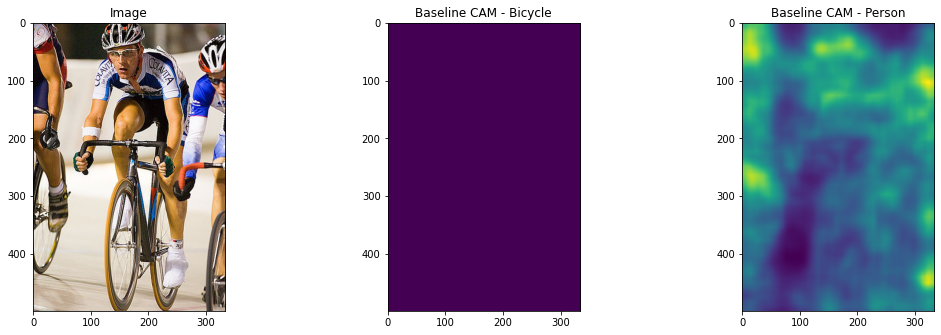

In [10]:
im = Image.open(os.path.join(voc12_root, 'JPEGImages', '2007_000129' + '.jpg'))

fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(331)
plt.title('Image')
ax1.imshow(im)
ax2 = fig.add_subplot(332)
plt.title('Baseline CAM - Bicycle')
ax2.imshow(frontdoor_highres_cam[0].squeeze())
ax3 = fig.add_subplot(333)
plt.title('Baseline CAM - Person')
ax3.imshow(frontdoor_highres_cam[1].squeeze())

In [41]:
from net import resnet50

class NetDualHeads(nn.Module):
    def __init__(self):
        super(NetDualHeads, self).__init__()

        self.resnet50 = resnet50.resnet50(
            pretrained=True, strides=(2, 2, 2, 1))
        self.stage1 = nn.Sequential(self.resnet50.conv1, self.resnet50.bn1, self.resnet50.relu, self.resnet50.maxpool,
                                    self.resnet50.layer1)
        self.stage2 = nn.Sequential(self.resnet50.layer2)
        self.stage3 = nn.Sequential(self.resnet50.layer3)
        self.stage4 = nn.Sequential(self.resnet50.layer4)

        self.classifier = nn.Conv2d(2048, 20, 1, bias=False)

        self.backbone = nn.ModuleList(
            [self.stage1, self.stage2, self.stage3, self.stage4])
        self.newly_added = nn.ModuleList([self.classifier])

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x).detach()
        x = self.stage3(x)
        x = self.stage4(x)

        logit = torchutils.gap2d(x, keepdims=True)
        logit = self.classifier(logit)
        logit = logit.view(-1, 20)

        cam = F.conv2d(x, self.classifier.weight)
        cam = F.relu(cam)
        cam = cam / (F.adaptive_max_pool2d(cam, (1, 1)) + 1e-5)
        return logit, cam

    def train(self, mode=True):
        for p in self.resnet50.conv1.parameters():
            p.requires_grad = False
        for p in self.resnet50.bn1.parameters():
            p.requires_grad = False

    def trainable_parameters(self):
        return (list(self.backbone.parameters()), list(self.newly_added.parameters()))

In [42]:
dm = NetDualHeads()
cam_learning_rate = 0.1
cam_weight_decay = 0.00001
max_step = (len(train_dataset) // 2) * 5

param_groups = dm.trainable_parameters()
optimizer = torchutils.PolyOptimizer([
    {'params': param_groups[0], 'lr': cam_learning_rate,
        'weight_decay': cam_weight_decay},
    {'params': param_groups[1], 'lr': 10 * cam_learning_rate,
        'weight_decay': cam_weight_decay},
], lr=cam_learning_rate, weight_decay=cam_weight_decay, max_step=max_step)

In [44]:
for pack in train_data_loader:
    imgs = pack['img']
    labels = pack['label']
    logit, cam  = dm(imgs)
    cls_loss = F.multilabel_soft_margin_loss(logit, labels)
    print(logit)
    cam_loss = F.multilabel_soft_margin_loss(torchutils.mean_agg(cam, r=1), labels)
    
    loss = cls_loss + cam_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(loss.item())

tensor([[ 0.3012, -0.4897,  0.2245, -0.1433, -0.0802, -0.2322, -0.1092,  0.2457,
         -0.0144, -0.1537,  0.0930,  0.0390, -0.1748, -0.2095,  0.2227,  0.0169,
          0.2915,  0.1886,  0.0763,  0.0680],
        [ 0.2819, -0.2773,  0.1371,  0.0645,  0.0822, -0.2463, -0.0321,  0.3612,
          0.2624, -0.0352,  0.1792,  0.2341, -0.1058, -0.2067,  0.2073, -0.0690,
          0.2885,  0.3736, -0.1742,  0.0230]], grad_fn=<ViewBackward0>)
1.4792520999908447
tensor([[ -1.5550,  -4.7350,  -7.1796,  -7.2491,  -6.9166,  -5.7463,  -6.0006,
          -7.7796,  -7.2868,  -6.7854,  -7.6204,  -8.2299,  -6.5619,  -5.9921,
          -6.8317,  -7.2264,  -7.9391,  -7.6543,   0.2161,  -6.8037],
        [ -2.8537,  -7.3158, -11.2342, -10.4867, -10.6095,  -8.8932,  -9.4327,
         -12.0603, -11.0759, -10.4229, -11.5169, -12.4418,  -9.7913,  -8.6733,
         -10.2539, -10.9034, -11.9521, -11.6169,   1.0837, -10.6544]],
       grad_fn=<ViewBackward0>)
0.9065588712692261
tensor([[-1.8312, -3.4454, -5.1

0.8850836157798767
tensor([[-3.2011, -3.1275, -4.1616, -2.2485, -2.7825, -3.1791, -3.0107, -4.2052,
         -3.2742, -3.5128, -3.0798, -3.5081, -3.2582, -3.9368, -0.6676, -2.8047,
         -2.9332, -2.6997, -2.6491, -3.0113],
        [-3.1891, -2.9884, -4.1125, -2.1760, -2.8576, -3.3662, -3.2004, -4.2962,
         -3.3688, -3.4878, -3.2615, -3.2433, -3.3620, -3.9662, -0.9450, -2.8788,
         -2.7738, -2.7974, -2.7448, -3.1008]], grad_fn=<ViewBackward0>)
0.9367886781692505
tensor([[-2.3738, -3.0518, -2.7228, -2.2301, -2.9289, -3.1567, -3.0016, -3.9447,
         -3.0218, -3.1254, -2.6739, -3.1459, -2.7484, -3.5706, -1.6136, -2.7684,
         -2.2427, -2.6710, -2.9105, -2.9931],
        [-1.9819, -2.5809, -2.2895, -1.7914, -2.5668, -2.6864, -2.6275, -3.4209,
         -2.4898, -2.8834, -2.2370, -2.7016, -2.4415, -3.1353, -1.0104, -2.3479,
         -2.0528, -2.0858, -2.6868, -2.4761]], grad_fn=<ViewBackward0>)
0.9402510523796082
tensor([[-1.9302, -1.8311, -2.4236, -2.0524, -2.3668, -2.63

KeyboardInterrupt: 